In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import inflect
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix

In [2]:
pd.options.mode.chained_assignment = None

In [3]:
sqf_cpw_filter = pd.read_csv('clean_sqf.csv')

In [343]:
sqf_cpw_filter['WEAPON_FOUND_FLAG'].value_counts()

N    10800
Y     2231
Name: WEAPON_FOUND_FLAG, dtype: int64

In [260]:
sqf_cpw_filter = sqf_cpw_filter.drop(columns=['STOP_DURATION_MINUTES', 
                                              #'OBSERVED_DURATION_MINUTES',
                                              #'OFFICER_IN_UNIFORM_FLAG', 
                                              'FRISKED_FLAG'])

In [261]:
p = inflect.engine()

sqf_cpw_filter['YEAR2'] = sqf_cpw_filter['YEAR2'].apply(lambda x: p.number_to_words(int(x)))
sqf_cpw_filter['MONTH2'] = sqf_cpw_filter['MONTH2'].apply(lambda x: p.number_to_words(int(x)))
sqf_cpw_filter['DAY2'] = sqf_cpw_filter['DAY2'].apply(lambda x: p.number_to_words(int(x)))
sqf_cpw_filter['STOP_LOCATION_PRECINCT'] = sqf_cpw_filter['STOP_LOCATION_PRECINCT'].apply(lambda x: p.number_to_words(int(x)))

In [262]:
# Convert to correct datatype --> object for categorical, float64 for numerical 
sqf_cpw_filter = sqf_cpw_filter.astype({'YEAR2': 'object',
                                        'OBSERVED_DURATION_MINUTES': 'float64',
                                        'OFFICER_IN_UNIFORM_FLAG': 'object',
                                        'STOP_LOCATION_PRECINCT': 'object',
                                        'LOCATION_IN_OUT_CODE': 'object', 'JURISDICTION_CODE': 'object',
                                        'SUSPECT_SEX': 'object', 'SUSPECT_RACE_DESCRIPTION': 'object',
                                        'SUSPECT_REPORTED_AGE': 'float64', 'SUSPECT_BODY_BUILD_TYPE': 'object',
                                        'SUSPECT_WEIGHT': 'float64', 'WEAPON_FOUND_FLAG': 'object', 
                                        'MONTH2': 'string', 'DAY2': 'string',
                                        'STOP_FRISK_TIME': 'float64'
                                        })

In [263]:
sqf_cpw_dropped = sqf_cpw_filter.dropna()
sqf_cpw_dropped.shape

(8386, 17)

In [342]:
sqf_cpw_dropped['WEAPON_FOUND_FLAG'].value_counts()

N    6990
Y    1396
Name: WEAPON_FOUND_FLAG, dtype: int64

In [330]:
def standardize_data(df_num, t1=0.2, t2=0.25):
    print(t1, t2)
    train, test = train_test_split(df_num, test_size=t1, random_state=1)
    train, val = train_test_split(train, test_size=t2, random_state=1)
    scaler = StandardScaler()
    train_scale = scaler.fit_transform(train)
    val_scale = scaler.transform(val)
    test_scale = scaler.transform(test)
    scaled_train = pd.DataFrame(train_scale, index=train.index, columns=train.columns)
    scaled_val = pd.DataFrame(val_scale, index=val.index, columns=val.columns)
    scaled_test = pd.DataFrame(test_scale, index=test.index, columns=test.columns)
    print(scaled_train.shape)
    return scaled_train, scaled_val, scaled_test

In [331]:
def process_data_simpleimputer(sqf_cpw, t1=0.2, t2=0.25):
    print(sqf_cpw.shape)
    weapon = 'WEAPON_FOUND_FLAG_Y'
    df_num = sqf_cpw.select_dtypes(['float64', 'int64'])
    df_cat = sqf_cpw.select_dtypes(['object', 'string'])
    cat = df_cat.columns
    print(cat)
    df_ohe = pd.get_dummies(df_cat, prefix=cat, columns=cat, drop_first=True)
    print(df_ohe.isna().sum())
    train_cat, test_cat = train_test_split(df_ohe, test_size=t1, random_state=1)
    train_cat, val_cat = train_test_split(train_cat, test_size=t2, random_state=1)
    train_num, val_num, test_num = standardize_data(df_num, t1, t2)
    train = train_num.join(train_cat, how='outer')
    val = val_num.join(val_cat, how='outer')
    test = test_num.join(test_cat, how='outer')
    train_x = train.drop([weapon], axis=1)
    val_x = val.drop([weapon], axis=1)
    test_x = test.drop([weapon], axis=1)
    # targets
    targets_train = train[weapon]
    targets_val = val[weapon]
    targets_test = test[weapon]
    
    return train_x, val_x, test_x, targets_train, targets_val, targets_test

In [332]:
from sklearn.metrics import confusion_matrix
def specificity(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    #print(tn)
    #print(fp)
    specificity = tn / (tn+fp)
    return specificity 

In [333]:
def weighted_accuracy(true, pred):
    assert(len(pred) == len(true))
    num_labels = len(true)
    num_pos = sum(true)
    num_neg = num_labels - num_pos 
    frac_pos = num_pos/num_labels 
    weight_pos = 1/frac_pos
    weight_neg = 1/(1-frac_pos)
    #print(weight_pos)
    #print(weight_neg)
    num_pos_correct = 0
    num_neg_correct = 0
    for pred_i, true_i in zip(pred, true): 
        num_pos_correct += (pred_i == true_i and true_i == 1) 
        num_neg_correct += (pred_i == true_i and true_i == 0) 
        weighted_accuracy = ((weight_pos * num_pos_correct) 
                             + (weight_neg * num_neg_correct))/((weight_pos * num_pos) + (weight_neg * num_neg)) 
    return weighted_accuracy 

In [334]:
b_train, b_val, b_test, targets_train_b, targets_val_b, targets_test_b = process_data_simpleimputer(sqf_cpw_dropped, 0.1, 1/9)

(8386, 17)
Index(['YEAR2', 'STOP_LOCATION_PRECINCT', 'LOCATION_IN_OUT_CODE',
       'JURISDICTION_CODE', 'OFFICER_IN_UNIFORM_FLAG', 'STOP_WAS_INITIATED',
       'SUSPECT_SEX', 'SUSPECT_RACE_DESCRIPTION', 'SUSPECT_BODY_BUILD_TYPE',
       'WEAPON_FOUND_FLAG', 'MONTH2', 'DAY2'],
      dtype='object')
YEAR2_two thousand and fifteen         0
YEAR2_two thousand and nineteen        0
YEAR2_two thousand and seventeen       0
YEAR2_two thousand and sixteen         0
STOP_LOCATION_PRECINCT_eighty-eight    0
                                      ..
DAY2_one                               0
DAY2_six                               0
DAY2_three                             0
DAY2_two                               0
DAY2_zero                              0
Length: 114, dtype: int64
0.1 0.1111111111111111
(6708, 5)


In [335]:
b_train.shape

(6708, 118)

### Linear SVM

In [336]:
svm_l = SVC(kernel='linear', degree=3, probability=True, class_weight='balanced', C=1, gamma=g)
svm_l.fit(b_train, targets_train_b)

SVC(C=1, class_weight='balanced', gamma=0.06158482110660261, kernel='linear',
    probability=True)

In [337]:
y_wacc_train_l = weighted_accuracy(targets_train_b, svm_l.predict(b_train))
y_wacc_val_l = weighted_accuracy(targets_val_b, svm_l.predict(b_val))
print('weightedacc train = ', y_wacc_train_l)
print('weighted acc val = ', y_wacc_val_l)

weightedacc train =  0.6899147863325669
weighted acc val =  0.6724175219220636


### RBF SVM

In [338]:
svm = SVC(kernel='rbf', degree=3, probability=True, class_weight='balanced', C=1, gamma=g)
svm.fit(b_train, targets_train_b)
#pred = svm.predict_proba(b_train)
#pred_val = svm.predict_proba(b_val)
#print('The AUC score of my training set:', roc_auc_score(targets_train_b, pred[:, 1]))
#print('The AUC score of my val set:', roc_auc_score(targets_val_b, pred_val[:, 1]))

SVC(C=1, class_weight='balanced', gamma=0.06158482110660261, probability=True)

In [339]:
y_wacc_train_b = weighted_accuracy(targets_train_b, svm.predict(b_train))
y_wacc_val_b = weighted_accuracy(targets_val_b, svm.predict(b_val))
print('weighted acc train = ', y_wacc_train_b)
print('weighted acc val = ', y_wacc_val_b)

weighted acc train =  0.7938031892788302
weighted acc val =  0.7070111281506822


In [329]:
y_wacc_test_b = weighted_accuracy(targets_test_b, svm.predict(b_test))
print('weighted acc test = ', y_wacc_test_b)

weighted acc test =  0.6440498737373738


### Optimize gamma 

In [215]:
gamma = 10**np.linspace(-5, -1, 20)

In [216]:
gamma

array([1.00000000e-05, 1.62377674e-05, 2.63665090e-05, 4.28133240e-05,
       6.95192796e-05, 1.12883789e-04, 1.83298071e-04, 2.97635144e-04,
       4.83293024e-04, 7.84759970e-04, 1.27427499e-03, 2.06913808e-03,
       3.35981829e-03, 5.45559478e-03, 8.85866790e-03, 1.43844989e-02,
       2.33572147e-02, 3.79269019e-02, 6.15848211e-02, 1.00000000e-01])

In [217]:
train_gamma_acc = []
val_gamma_acc = []

for i in gamma:  
    svm = SVC(kernel='rbf', degree=3, probability=True, class_weight='balanced', gamma=i)
    svm.fit(b_train, targets_train_b)
    pred_train = svm.predict(b_train)
    pred_val = svm.predict(b_val)
    train_gamma_acc.append(weighted_accuracy(targets_train_b, pred_train))
    val_gamma_acc.append(weighted_accuracy(targets_val_b, pred_val))

In [218]:
# train_scores_mean = np.mean(train_scores, axis=1)
# train_scores_std = np.std(train_scores, axis=1)
# test_scores_mean = np.mean(test_scores, axis=1)
# test_scores_std = np.std(test_scores, axis=1)

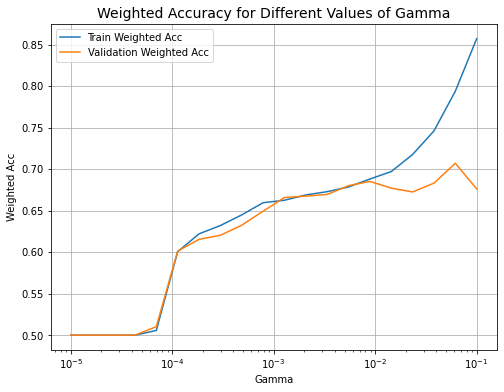

In [225]:
#plotting regularization strength vs. AUC score for train, val, and test
plt.figure(figsize=(8, 6))
plt.semilogx(gamma, train_gamma_acc, label='Train Weighted Acc')
plt.semilogx(gamma, val_gamma_acc, label='Validation Weighted Acc')
# plt.fill_between(gamma, test_scores_mean - test_scores_std,
#                  test_scores_mean + test_scores_std, alpha=0.2,
#                  color="navy", lw=lw)
plt.xlabel("Gamma")
plt.ylabel("Weighted Acc")
plt.title("Weighted Accuracy for Different Values of Gamma", size=14)
plt.grid()
plt.legend()

In [220]:
#choose gamma hyperparam where validation performs best
gamma_index = np.array(val_gamma_acc).argmax()
g = gamma[gamma_index]
g

0.06158482110660261

### Optimize c using auc

In [221]:
c = 10**np.linspace(-2, 0, 20)

In [144]:
# train_c_auc = []
# val_c_auc = []

# for i in c:  
#     svm = SVC(kernel='rbf', degree=3, probability=True, class_weight='balanced', C=i)
#     svm.fit(b_train, targets_train_b)
#     pred_train = svm.predict_proba(b_train)[:,1]
#     pred_val = svm.predict_proba(b_val)[:,1]
#     train_c_auc.append(roc_auc_score(targets_train_b, pred_train))
#     val_c_auc.append(roc_auc_score(targets_val_b, pred_val))

In [145]:
# #plotting regularization strength vs. AUC score for train, val, and test
# plt.figure(figsize=(8, 6))
# plt.plot(c, train_c_auc, label='Train AUC')
# plt.plot(c, val_c_auc, label='Validation AUC')
# plt.xlabel("Strength of Regularization Parameter")
# plt.ylabel("AUC Score")
# plt.title("AUC Score for Different Values of C (Regularization Parameter)", size=14)
# plt.grid()
# plt.legend()

### Optimize c using weighted acc

In [102]:
# from imblearn.under_sampling import RandomUnderSampler 

# sqf_cpw_dropped['WEAPON_FOUND_FLAG'].value_counts()
# sqf_cpw_y = sqf_cpw_dropped['WEAPON_FOUND_FLAG']
# sqf_cpw_x = sqf_cpw_dropped.drop(columns=['WEAPON_FOUND_FLAG'])

# rus = RandomUnderSampler(random_state=42)
# X_res, y_res = rus.fit_resample(sqf_cpw_x, sqf_cpw_y)
# sqf = X_res.copy()
# sqf['WEAPON_FOUND_FLAG'] = y_res

In [340]:
train_c_w_acc = []
val_c_w_acc = []

for i in c:  
    svm = SVC(kernel='rbf', degree=3, probability=True, class_weight='balanced', C=i, gamma=g)
    svm.fit(b_train, targets_train_b)
    pred_train = svm.predict(b_train)
    pred_val = svm.predict(b_val)
    train_c_w_acc.append(weighted_accuracy(targets_train_b, pred_train))
    val_c_w_acc.append(weighted_accuracy(targets_val_b, pred_val))

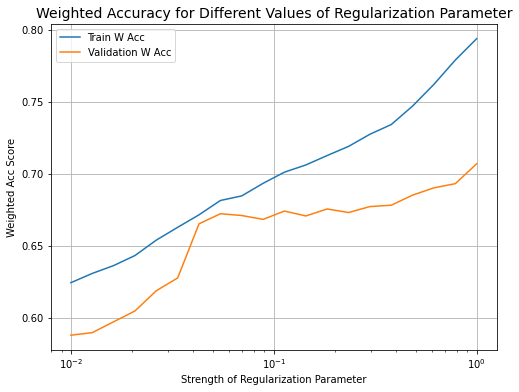

In [341]:
#plotting regularization strength vs. AUC score for train, val, and test
plt.figure(figsize=(8, 6))
plt.semilogx(c, np.array(train_c_w_acc), label='Train W Acc')
plt.semilogx(c, np.array(val_c_w_acc), label='Validation W Acc')
plt.xlabel("Strength of Regularization Parameter")
plt.ylabel("Weighted Acc Score")
plt.title("Weighted Accuracy for Different Values of Regularization Parameter", size=14)
plt.grid()
plt.legend()

In [155]:
np.array(val_c_w_acc).max()

0.7070111281506822

In [152]:
#choose gamma hyperparam where validation performs best
c_index = np.array(val_c_w_acc).argmax()
c_opt = c[c_index]
c_opt

1.0

### Recall/Specificity

In [298]:
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
w = [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8, 8.5, 9]
r_train = []
r_val = []
s_train = []
s_val = []
wa_train = []
wa_val = []
a_train = []
a_val = []

for i in w:
    svm_weights = SVC(kernel='rbf', degree=3, probability=True, class_weight={0: 1, 1: i}, C=c_opt, gamma=g)
    svm_weights.fit(b_train, targets_train_b)
    
    y_pred_train = svm_weights.predict(b_train)
    y_pred_val = svm_weights.predict(b_val)
    
    recall_train_b = recall_score(targets_train_b, y_pred_train)
    r_train.append(recall_train_b)
    recall_val_b = recall_score(targets_val_b, y_pred_val)
    r_val.append(recall_val_b)
    
    sp_train_b = specificity(targets_train_b, y_pred_train)
    s_train.append(sp_train_b)
    sp_val_b = specificity(targets_val_b, y_pred_val)
    s_val.append(sp_val_b)
    
    wacc_train_b = weighted_accuracy(targets_train_b, y_pred_train)
    wa_train.append(wacc_train_b)
    wacc_val_b = weighted_accuracy(targets_val_b, y_pred_val)
    wa_val.append(wacc_val_b)
    
    acc_train_b = accuracy_score(targets_train_b, y_pred_train)
    a_train.append(acc_train_b)
    acc_val_b = accuracy_score(targets_val_b, y_pred_val)
    a_val.append(acc_val_b)

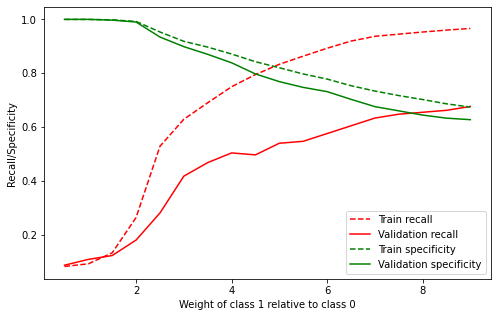

In [299]:
plt.figure(figsize=(8,5))
plt.plot(w, r_train, c='red', label='Train recall', ls='--')
plt.plot(w, r_val, c='red', label='Validation recall')
plt.plot(w, s_train, c='green', label='Train specificity', ls='--')
plt.plot(w, s_val, c='green', label='Validation specificity')
plt.xlabel('Weight of class 1 relative to class 0')
plt.ylabel('Recall/Specificity')
plt.legend()

In [ ]:
### Random RFC stuff :/ 

In [103]:
train, val, test, train_y, val_y, test_y = process_data_simpleimputer(sqf, 0.1, 1/9)

0.1 0.1111111111111111


In [104]:
# train, test = train_test_split(sqf, test_size=0.1, random_state=1)
# train, val = train_test_split(train, test_size=1/9, random_state=1)
# train_y = train['WEAPON_FOUND_FLAG']
# val_y = val['WEAPON_FOUND_FLAG']
# test_y = test['WEAPON_FOUND_FLAG']
# train = train.drop(columns='WEAPON_FOUND_FLAG')
# val = val.drop(columns='WEAPON_FOUND_FLAG')
# test = test.drop(columns='WEAPON_FOUND_FLAG')

In [118]:
clf = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=0 
                             class_weight='balanced')
clf.fit(train, train_y)

RandomForestClassifier(max_depth=10, n_estimators=200, random_state=0)

In [119]:
pred_t = clf.predict_proba(train)[:,1]
pred_v = clf.predict_proba(val)[:,1]
print(roc_auc_score(train_y, pred_t))
print(roc_auc_score(val_y, pred_v))

0.9283926608539534
0.730802591968978


In [ ]:
pred_test = clf.predict(train)
pred_val = clf.predict(val)
print(weighted_accuracy(train_y, pred_t))
print(weighted_accuracy(val_y, pred_v))

/Users/eeshakhanna/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


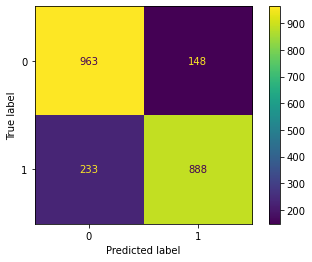

In [120]:
plot_confusion_matrix(clf, train, train_y) 

/Users/eeshakhanna/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


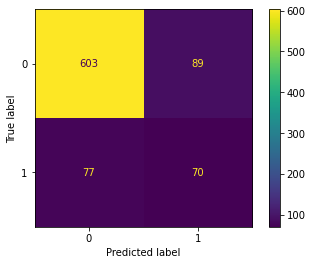

In [86]:
plot_confusion_matrix(clf, b_val, targets_val_b) 

### DFE

In [156]:
# df_num = sqf_cpw_dropped.select_dtypes(['float64', 'int64'])
# df_cat = sqf_cpw_dropped.select_dtypes(['object', 'string'])
# cat = df_cat.columns
# df_ohe = pd.get_dummies(df_cat, prefix=cat, columns=cat, drop_first=True)
# df_join = df_num.join(df_ohe, how='outer').drop(columns='WEAPON_FOUND_FLAG_Y')

In [169]:
sqf_cpw = sqf_cpw_dropped.copy().drop(columns=['WEAPON_FOUND_FLAG'])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8386 entries, 0 to 13030
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   YEAR2                      8386 non-null   object 
 1   STOP_LOCATION_PRECINCT     8386 non-null   object 
 2   LOCATION_IN_OUT_CODE       8386 non-null   object 
 3   JURISDICTION_CODE          8386 non-null   object 
 4   OBSERVED_DURATION_MINUTES  8386 non-null   float64
 5   OFFICER_IN_UNIFORM_FLAG    8386 non-null   object 
 6   STOP_WAS_INITIATED         8386 non-null   object 
 7   SUSPECT_SEX                8386 non-null   object 
 8   SUSPECT_RACE_DESCRIPTION   8386 non-null   object 
 9   SUSPECT_REPORTED_AGE       8386 non-null   float64
 10  SUSPECT_WEIGHT             8386 non-null   float64
 11  SUSPECT_BODY_BUILD_TYPE    8386 non-null   object 
 12  WEAPON_FOUND_FLAG          8386 non-null   object 
 13  SUSPECT_HEIGHT             8386 non-null   floa

In [170]:
sqf_cpw_dropped['STOP_WAS_INITIATED'].value_counts()

Y    4363
N    4023
Name: STOP_WAS_INITIATED, dtype: int64

In [174]:
from woodwork.logical_types import Categorical, PostalCode

import featuretools as ft

# # Create Entity
es = ft.EntitySet(id = 'sqf_cpw_dropped')
es = es.add_dataframe(
    dataframe_name="sqf_cpw_dropped",
    dataframe=sqf_cpw_dropped,
    index="index",
    logical_types={
        "YEAR2": Categorical,
        "STOP_LOCATION_PRECINCT": Categorical,
        "LOCATION_IN_OUT_CODE": Categorical,
        "JURISDICTION_CODE": Categorical,
        "OFFICER_IN_UNIFORM_FLAG": Categorical,
        "STOP_WAS_INITIATED": Categorical,
        "SUSPECT_SEX": Categorical,
        "SUSPECT_RACE_DESCRIPTION": Categorical,
        "SUSPECT_REPORTED_AGE": Categorical,
        "SUSPECT_BODY_BUILD_TYPE": Categorical,
        "MONTH2": Categorical,
        "DAY2" :Categorical},)

es

/Users/eeshakhanna/opt/anaconda3/lib/python3.7/site-packages/featuretools/entityset/entityset.py:1568: UserWarning: index index not found in dataframe, creating new integer column
  "integer column".format(index))


Entityset: sqf_cpw_dropped
  DataFrames:
    sqf_cpw_dropped [Rows: 8386, Columns: 18]
  Relationships:
    No relationships

In [175]:
# Run deep feature synthesis with transformation primitives
feature_matrix, feature_defs = ft.dfs(entityset = es, target_dataframe_name = 'sqf_cpw_dropped',
                                      trans_primitives = ['add_numeric', 'multiply_numeric'], 
                                      verbose=True)

Built 29 features
Elapsed: 00:00 | Progress: 100%|██████████


/Users/eeshakhanna/opt/anaconda3/lib/python3.7/site-packages/featuretools/synthesis/deep_feature_synthesis.py:156: UserWarning: Only one dataframe in entityset, changing max_depth to 1 since deeper features cannot be created
  warnings.warn("Only one dataframe in entityset, changing max_depth to "


In [178]:
feature_matrix['WEAPON_FOUND_FLAG'] = sqf_cpw_dropped['WEAPON_FOUND_FLAG']

In [189]:
feature_matrix_cat = feature_matrix.select_dtypes('category').astype('object')
feature_matrix_num = feature_matrix.select_dtypes(['float64', 'int64'])
dfs = feature_matrix_num.join(feature_matrix_cat, how='outer')

In [190]:
dfs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8386 entries, 0 to 8385
Data columns (total 29 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   OBSERVED_DURATION_MINUTES                    8386 non-null   float64
 1   SUSPECT_WEIGHT                               8386 non-null   float64
 2   SUSPECT_HEIGHT                               8386 non-null   float64
 3   STOP_FRISK_TIME                              8386 non-null   float64
 4   OBSERVED_DURATION_MINUTES + STOP_FRISK_TIME  8386 non-null   float64
 5   OBSERVED_DURATION_MINUTES + SUSPECT_HEIGHT   8386 non-null   float64
 6   OBSERVED_DURATION_MINUTES + SUSPECT_WEIGHT   8386 non-null   float64
 7   STOP_FRISK_TIME + SUSPECT_HEIGHT             8386 non-null   float64
 8   STOP_FRISK_TIME + SUSPECT_WEIGHT             8386 non-null   float64
 9   SUSPECT_HEIGHT + SUSPECT_WEIGHT              8386 non-null   float64
 10  

In [197]:
dfs_train, dfs_val, dfs_test, targets_train_dfs, targets_val_dfs, targets_test_dfs = process_data_simpleimputer(dfs, 0.1, 1/9)

Index(['YEAR2', 'STOP_LOCATION_PRECINCT', 'LOCATION_IN_OUT_CODE',
       'JURISDICTION_CODE', 'OFFICER_IN_UNIFORM_FLAG', 'STOP_WAS_INITIATED',
       'SUSPECT_SEX', 'SUSPECT_RACE_DESCRIPTION', 'SUSPECT_REPORTED_AGE',
       'SUSPECT_BODY_BUILD_TYPE', 'WEAPON_FOUND_FLAG', 'MONTH2', 'DAY2'],
      dtype='object')
0.1 0.1111111111111111


In [202]:
dfs_train.columns == dfs_val.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [205]:
svm_dfs = SVC(kernel='rbf', degree=3, probability=True, class_weight='balanced', C=1, gamma=g)
svm_dfs.fit(dfs_train, targets_train_dfs)
#pred = svm.predict_proba(b_train)
#pred_val = svm.predict_proba(b_val)
#print('The AUC score of my training set:', roc_auc_score(targets_train_b, pred[:, 1]))
#print('The AUC score of my val set:', roc_auc_score(targets_val_b, pred_val[:, 1]))

SVC(C=1, class_weight='balanced', gamma=0.06158482110660261, probability=True)

In [206]:
y_wacc_train_dfs = weighted_accuracy(targets_train_dfs, svm_dfs.predict(dfs_train))
y_wacc_val_dfs = weighted_accuracy(targets_val_dfs, svm_dfs.predict(dfs_val))
print('weightedacc train = ', y_wacc_train_dfs)
print('weighted acc val = ', y_wacc_val_dfs)

weightedacc train =  0.8468328458515232
weighted acc val =  0.64196256537297
